# Nonlinear Regression of the SUPCRTBL database

The SUPCRTBL database was created by members of the Zhu Laboratory at IUB to aid in geochemical modeling of aqueous minerals, in particular Rare Earth Elements (REEs).

An excel copy of the database has been provided, file name "spronsbl_aqeousREE_ref".

The goal of this nonlinear regression is to find a trend in the data and create a model for predicting values of minerals not yet in the database.

![shock et al Fig 9, major ion correlations of entropy and standard mol vols](https://github.com/cookjan/G690_jcc/tree/main/research_project/images/Shock_fig9.png)

It has been known that minerals of similar qualities have statistically predictable trends in values such as standard molecular volume and entropy, as shown here. This figure is from Shock et al. (1997). This paper and others like it are the inspiration for searching out new correlations in the fundamental workings of aqueous mineral geochemistry. 

Ref: Shock, E. L., Sassani, D. C., Willis, M., & Sverjensky, D. A. (1997). Inorganic species in geologic fluids: correlations among standard molal thermodynamic properties of aqueous ions and hydroxide complexes. Geochimica et Cosmochimica Acta, 61(5), 907-950.


First we will import libraries we need and take a look at the data.

In [1]:
"""import libraries"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import xarray as xr
import torch
import torch.nn as nn
import os


In [2]:
""" Read the tmin data file. """
filename = r"C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\research_project\spronsbl_aqueousREE_ref.xlsx"

# read in the data file, 
supcrtbl = pd.read_excel(filename, sheet_name = "core", header = 0, skiprows = 0)

# show the top of the dataset
supcrtbl.head()

,supcrtbl_aqueous_tb_id,Data_source,Species_type,Name,Structural_formula,Abbreviation,Chemical_formula,Reference,Date,"Gibbs_free_energy_of_formation (DGf0, kJ/mol)","Enthalpy_of_formation (DHf0, kJ/mol)","Entropy (S0, J/mol/K)",a1_HKF_coefficient (10^1 J/mol/bar),a2_HKF_coefficient_a2 (10^-2 J/mol),a3_HKF_coefficient (J*K/mol/bar),a4_HKF_coefficient (10^-4 J*K/mol),c1_HKF_coefficient (J/mol/K),c2_HKF_coefficient (10^-4 J*K/mol),"Born_coefficient (omega, 10^-5 J/mol)",Charge
0,314,supcrtbl.dat,Type 6,Rh(SO4)3-4,Rh(SO4)3-4,Rh(SO4)3-4,Rh(1)S(3)O(12)-(4),SS98,30.mar.95,-2150.994,-2595.335,128.867,42.6027,71.4715,-4.1706,-14.5817,129.1011,-57.4668,25.1940,-4
1,336,supcrtbl.dat,Type 6,Ru(SO4)3-4,Ru(SO4)3-4,Ru(SO4)3-4,Ru(1)S(3)O(12)-(4),SS98,30.mar.95,-2112.083,-2553.077,136.817,43.0726,72.6162,-4.4878,-14.6289,129.9605,-56.7932,25.0772,-4
2,1048,supcrtbl.dat,Type 6,UO2(Ac)3-,UO2(CH3COO)3-,UO2(Ac)3-,U(1)C(6)H(9)O(8)-(1),SK93,9,-2102.042,-2543.705,76.567,108.8263,233.1718,-67.6013,-21.2664,1151.9435,360.6001,5.6593,-1
3,279,supcrtbl.dat,Type 6,Pd(SO4)3-4,Pd(SO4)3-4,Pd(SO4)3-4,Pd(1)S(3)O(12)-(4),SS98,28.jul.94,-2091.582,-2526.927,164.850,44.7998,76.8375,-6.1555,-14.8034,134.6867,-53.7761,24.6479,-4
4,335,supcrtbl.dat,Type 6,Ru(SO4)3-3,Ru(SO4)3-3,Ru(SO4)3-3,Ru(1)S(3)O(12)-(3),SS98,30.mar.95,-2071.917,-2486.133,161.921,36.3096,56.1070,1.9887,-13.9465,12.4574,-73.9242,17.6728,-3


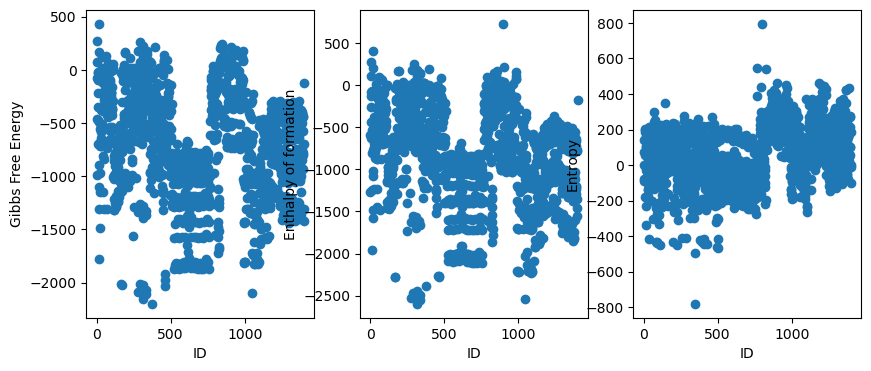

In [3]:
"""plot data to see if theres any trend"""
# plot the noisy data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 4))
ax1.scatter(supcrtbl['supcrtbl_aqueous_tb_id'], supcrtbl['Gibbs_free_energy_of_formation (DGf0, kJ/mol)'])
ax2.scatter(supcrtbl['supcrtbl_aqueous_tb_id'], supcrtbl['Enthalpy_of_formation (DHf0, kJ/mol)'])
ax3.scatter(supcrtbl['supcrtbl_aqueous_tb_id'], supcrtbl['Entropy (S0, J/mol/K)'])

ax3.set_xlabel("ID")
ax2.set_xlabel("ID")
ax1.set_xlabel("ID")
ax1.set_ylabel("Gibbs Free Energy")
ax2.set_ylabel("Enthalpy of formation")
ax3.set_ylabel("Entropy")
plt.show()

This gives us some clues as to how the data is grouped, best seen in plot 1. 

In [18]:
"""figure out which data to look at by graphing data colummns"""

def generate_plot(
        #plot inputs will be column names
        i : str,
        j : str,
        
        #set output directory where plots are saved
        output_dir = "./HKFplots/"):

        # prevent matplotlib from displaying the plot
        plt.ioff()

        # make sure the output directory exists
        os.makedirs(output_dir, exist_ok=True)

        #plot the data
        fig, ax = plt.subplots(figsize=(10, 10))

        #look at middle 90% of data so we dont see outliers
        #supcrtbl_I = I[
        #        ([I > I.quantile(.05)]) 
        #        & 
        #        ([I < I.quantile(.95)] )]
        #supcrtbl_adj = supcrtbl_np[
        #        ([supcrtbl_np[i] > supcrtbl_np[i].quantile(.05)]) 
        #        & 
        #        ([supcrtbl_np[i] < supcrtbl_np[i].quantile(.95)] )]
        #supcrtbl_adj = supcrtbl_np[
        #        ([int(supcrtbl_np[i])> (int(supcrtbl_np[i])).quantile(.05)]) 
        #        & 
        #        ([int(supcrtbl_np[i]) < int(supcrtbl_np[i]).quantile(.95)] )]
        #supcrtbl_adj = supcrtbl[
        #        ([supcrtbl[i] > supcrtbl[i].quantile(.05)]) 
        #        & 
        #        ([supcrtbl[i] < supcrtbl[i].quantile(.95)] )]
       # supcrtbl_adj = supcrtbl[
        #        ([np.array.supcrtbl[i] > np.array.supcrtbl[i].quantile(.05)]) 
        #        & 
        #        ([np.array.supcrtbl[i] < np.array.supcrtbl[i].quantile(.95)] )]
                #this didnt work

        #add colors so they dont look really boring
        import random
 
        def random_color_generator():
                r = (random.randint(0, 255))/255
                g = (random.randint(0, 255))/255
                b = (random.randint(0, 255))/255
                return (r, g, b)
 
        random_color = random_color_generator()

        #plot the data
        ax.scatter(supcrtbl[i], supcrtbl[j], color = random_color)

        # set the title of plot and axes
        ax.set_title(f"HKF Correlation of {i} and {j}", fontsize=12)
        ax.set_xlabel(i)
        ax.set_ylabel(j)
        
        # save the plot
        output_file = os.path.join(output_dir, f"plt_{i[:8]}_{j[:8]}.png")
        # save the plot
        fig.savefig(output_file, dpi=300, bbox_inches="tight")

        # close the figure
        plt.close(fig)

        return output_file


In [5]:
#create the headers list for the plot generation loop
headers = pd.read_excel(filename, sheet_name = "core").columns
trunc_headers = headers[9:]
trunc_headers


Index(['Gibbs_free_energy_of_formation (DGf0, kJ/mol)',
       'Enthalpy_of_formation (DHf0, kJ/mol)', 'Entropy (S0, J/mol/K)',
       'a1_HKF_coefficient (10^1 J/mol/bar)',
       'a2_HKF_coefficient_a2 (10^-2 J/mol)',
       'a3_HKF_coefficient (J*K/mol/bar)',
       'a4_HKF_coefficient (10^-4 J*K/mol)', 'c1_HKF_coefficient (J/mol/K)',
       'c2_HKF_coefficient (10^-4 J*K/mol)',
       'Born_coefficient (omega, 10^-5 J/mol)', 'Charge'],
      dtype='object')

In [19]:
#test generate_plot function before creating 50 figs

generate_plot(trunc_headers[1],trunc_headers[4])

'./HKFplots/plt_Enthalpy_a2_HKF_c.png'

Now we will create 

In [20]:
#execute for loop to create graphs
for label in trunc_headers:
    for label2 in trunc_headers:
        if label == label2:
            None #get rid of 'same x and y' graphs

        else: generate_plot(label, label2)
        #would be nice to keep from making duplicate graphs (ie, x vs y and y vs x are made)

110 Plots were created. However, half of these are repeated plots (plots that show realtionship between the same two variables, but plot 1 has them on x and y and plot 2 has them on y and x).

![sketch of graph and table outputs for an example location, time, and ion](https://github.com/cookjan/G690_jcc/blob/main/research_project/proposalimage.png)

In [8]:
class Net(nn.Module):

    def __init__(self, n_relus : int = 2): #int tels py that n_relus is an integer w default val 2
        #iniitalize the parent class
        super().__init__()

        #create a neural network
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, n_relus), #layer 1 #n_relus is our output, which is defined as having 2 parts above
            nn.ReLU(), #layer 2
            nn.Linear(n_relus, 1), #layer 3 #both a linear operation on inputs and a sum

        )
    
    def forward(self, x):
        """Define the forward pass; how the network should act like a funciton"""
        out = self.linear_relu_stack(x)
        return  out